# 0. Install dependencies

In [1]:
# 0. Install dependencies
!pip install google-play-scraper
!pip install tensorflow
!pip install pandas
!pip install nltk
!pip install matplotlib
!pip install pipreqs

# 1. Pengumpulan Data (Scraping dengan Google Play Scraper)

In [2]:
from google_play_scraper import app, reviews_all, reviews, Sort
import pandas as pd

# 1. Pengumpulan Data (Scraping dengan Google Play Scraper)
#app_id = 'co.id.bankbsi.superapp'
#reviews = reviews_all(app_id)

# Scraping reviews for BYOND by BSI app
result, _ = reviews(
    'co.id.bankbsi.superapp',  # App ID for BYOND by BSI
    lang='id',                # Language: Indonesian
    country='id',             # Country: Indonesia
    sort=Sort.NEWEST,         # Sort by newest reviews
    count=10000                # Minimum 10000 reviews
)

# Convert ke DataFrame
#df = pd.DataFrame(reviews)
df = pd.DataFrame(result)

# Simpan hasil scraping ke CSV
df.to_csv('byond_bsi_reviews.csv', index=False)
print("Data has been saved to 'byond_bsi_reviews.csv'")

Data has been saved to 'byond_bsi_reviews.csv'


# 2. Pra-pemrosesan Data

In [3]:
import nltk
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 2. Pra-pemrosesan Data
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Pembersihan Data
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()
    return text

df['cleaned_text'] = df['content'].apply(clean_text)

# Tokenisasi, stopwords removal, dan stemming
stop_words = set(stopwords.words('indonesian'))
stemmer = PorterStemmer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['processed_text'] = df['cleaned_text'].apply(preprocess_text)

# Pelabelan Sentimen: Label sentimen manual
df['sentiment'] = df['content'].apply(lambda x: 1 if 'baik' in x else 0)

# Simpan dataset yang telah diproses
df.to_csv('byond_bsi_reviews_processed.csv', index=False)
print("Processed data has been saved to 'byond_bsi_reviews_processed.csv'")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Processed data has been saved to 'byond_bsi_reviews_processed.csv'


# 3. Pembuatan Model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 3. Pembuatan Model
# Pembagian data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment'], test_size=0.2)

# Representasi teks menggunakan TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model LSTM
model = Sequential([
    Embedding(input_dim=1000, output_dim=128, input_length=1000),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Melatih model
history = model.fit(X_train_tfidf.toarray(), y_train, epochs=5, batch_size=64, validation_data=(X_test_tfidf.toarray(), y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 736s 6s/step - accuracy: 0.8779 - loss: 0.3559 - val_accuracy: 0.9035 - val_loss: 0.3200
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 772s 6s/step - accuracy: 0.9016 - loss: 0.3237 - val_accuracy: 0.9035 - val_loss: 0.3191
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 756s 6s/step - accuracy: 0.9018 - loss: 0.3245 - val_accuracy: 0.9035 - val_loss: 0.3185
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 798s 6s/step - accuracy: 0.9053 - loss: 0.3153 - val_accuracy: 0.9035 - val_loss: 0.3188
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 820s 6s/step - accuracy: 0.9025 - loss: 0.3203 - val_accuracy: 0.9035 - val_loss: 0.3173


# 4. Evaluasi Model

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 4. Evaluasi Model
# Prediksi hasil
y_pred = model.predict(X_test_tfidf.toarray())
#y_pred = (y_pred > 0.5).astype(int)
y_pred = (y_pred > 0.3).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred) * 100  # Convert to percentage
precision = precision_score(y_test, y_pred) * 100  # Convert to percentage
recall = recall_score(y_test, y_pred) * 100  # Convert to percentage
f1 = f1_score(y_test, y_pred) * 100  # Convert to percentage

print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1-Score: {f1:.2f}%')

63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step
Accuracy: 90.35%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 5. Visualisasi Hasil

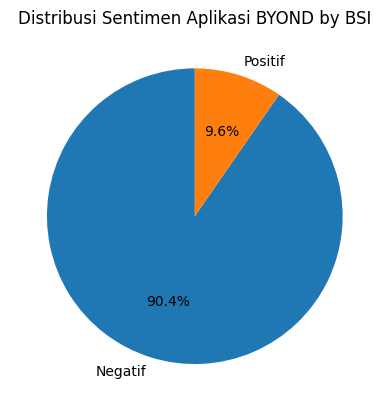

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 5. Visualisasi Hasil
# Visualisasi distribusi sentimen
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=['Negatif', 'Positif'])
plt.title('Distribusi Sentimen Aplikasi BYOND by BSI')
plt.ylabel('')
plt.show()

# 6. Create requirements file

In [7]:
!pipreqs . --force

import joblib

# Save model
joblib.dump(model, 'sentiment_model.pkl')

# Save TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Unduh file model
from google.colab import files
files.download('sentiment_model.pkl')

INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in ./requirements.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>